# 09. Integrating Polars Into the Data Science Workflow

By this point in this course, we've gained a lot of dexterity with `polars`; now, it's time to use it in a real data science problem!

The problem we will be trying to solve is **tip amount prediction**, using the NYC taxi rides data that we've been using throughout this course. The goal here is to provide a service to taxi drivers which, before starting a taxi ride, they can plug the details of their ride into, and receive a prediction for what tip amount that customer can be expected to pay. They could then use this information to inform themselves on how to best interact with their passengers to increase their tip; furthermore, feature importance insights from such a model could help a taxi driver decide the best places in the city to work, or the best times in the week, etc.

We'll go through the entire data science process:
1. Setting Up the Environment
2. Loading Data
4. Brief Data Exploration
3. Cleaning and Preparing the Data
4. Feature Engineering and Selection
5. Model Building
6. Model Evaluation
7. Discussion

And we'll also check out a few new data science tools in the `polars` library along the way.

Let's get into it!

## 9.1. Setting up the Environment

Import `polars` as usual...

In [1]:
import polars as pl

But also import some other tools from the data science suite that we'll need throughout this notebook.

In [2]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

## 9.2. Loading Data

First, we load the data about zones:

In [4]:
zone_column_rename_mapping = {
    "LocationID": "location_id",
    "Borough": "borough",
    "Zone": "zone",
}
zones_df = (
    pl.read_parquet("../data/taxi_zone_lookup.parquet")
    .rename(zone_column_rename_mapping)
)
zones_df.head()

location_id,borough,zone,service_zone
i32,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""


Then, we load in the yellow trips taxi data, for both february and march (using `*` file pattern notation), joining in the zone information as before:

In [5]:
yellow_rides_column_rename_mapping = {
    "VendorID": "vendor_id",
    "RatecodeID": "ratecode_id",
    "PULocationID": "pu_location_id",
    "DOLocationID": "do_location_id",
    "Airport_fee": "airport_fee",
}

zone_df_columns = ["borough", "zone", "service_zone",]

rides_df_raw = (
    pl.read_parquet("../data/yellow_tripdata_2024-*.parquet")
    .rename(yellow_rides_column_rename_mapping)
    .join(zones_df, left_on="pu_location_id", right_on="location_id")
    .rename({zone_df_column: f"pu_{zone_df_column}" for zone_df_column in zone_df_columns})
    .join(zones_df, left_on="do_location_id", right_on="location_id")
    .rename({zone_df_column: f"do_{zone_df_column}" for zone_df_column in zone_df_columns})
)

In [6]:
display(rides_df_raw.shape)
display(rides_df_raw.head())

(6590154, 25)

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
2,2024-02-01 00:04:45,2024-02-01 00:19:58,1,4.39,1,"""N""",68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0,"""Manhattan""","""East Chelsea""","""Yellow Zone""","""Manhattan""","""Upper East Side North""","""Yellow Zone"""
2,2024-02-01 00:56:31,2024-02-01 01:10:53,1,7.71,1,"""N""",48,243,1,31.0,1.0,0.5,9.0,0.0,1.0,45.0,2.5,0.0,"""Manhattan""","""Clinton East""","""Yellow Zone""","""Manhattan""","""Washington Heights North""","""Boro Zone"""
2,2024-02-01 00:07:50,2024-02-01 00:43:12,2,28.69,2,"""N""",132,261,2,70.0,0.0,0.5,0.0,6.94,1.0,82.69,2.5,1.75,"""Queens""","""JFK Airport""","""Airports""","""Manhattan""","""World Trade Center""","""Yellow Zone"""
1,2024-02-01 00:01:49,2024-02-01 00:10:47,1,1.1,1,"""N""",161,163,1,9.3,3.5,0.5,2.85,0.0,1.0,17.15,2.5,0.0,"""Manhattan""","""Midtown Center""","""Yellow Zone""","""Manhattan""","""Midtown North""","""Yellow Zone"""
1,2024-02-01 00:37:35,2024-02-01 00:51:15,1,2.6,1,"""N""",246,79,2,15.6,3.5,0.5,0.0,0.0,1.0,20.6,2.5,0.0,"""Manhattan""","""West Chelsea/Hudson Yards""","""Yellow Zone""","""Manhattan""","""East Village""","""Yellow Zone"""


Looks good to go!

## 9.3. Brief Data Exploration

Before we proceed with any machine learning, let's first have a look at the data, viewed through the lens of the machine learning problem we're going to solve, keeping an eye out for anything we'll need to take care of during data cleaning and preparation:

In [7]:
rides_df_raw.describe()

statistic,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""",6.590154e6,"""6590154""","""6590154""",5.978354e6,6.590154e6,5.978354e6,"""5978354""",6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,5.978354e6,5.978354e6,"""6590154""","""6590154""","""6590154""","""6590154""","""6590154""","""6590154"""
"""null_count""",0.0,"""0""","""0""",611800.0,0.0,611800.0,"""611800""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,611800.0,611800.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",1.756811,"""2024-03-02 23:29:08.306262""","""2024-03-02 23:45:29.766303""",1.332109,4.217783,2.189424,null,164.836847,163.769507,1.103447,18.39262,1.400976,0.48309,3.241934,0.526057,0.974779,26.894141,2.259032,0.136208,null,null,null,null,null,null
"""std""",0.430632,null,null,0.836458,281.631336,10.395004,null,64.242165,69.446392,0.622692,18.359656,1.804078,0.119625,3.941163,2.122793,0.221227,22.897657,0.826409,0.48108,null,null,null,null,null,null
"""min""",1.0,"""2002-12-31 22:17:10""","""2002-12-31 22:42:24""",0.0,0.0,1.0,"""N""",1.0,1.0,0.0,-999.0,-7.5,-0.5,-300.0,-84.3,-1.0,-1000.0,-2.5,-1.75,"""Bronx""","""Allerton/Pelham Gardens""","""Airports""","""Bronx""","""Allerton/Pelham Gardens""","""Airports"""
"""25%""",2.0,"""2024-02-16 23:06:24""","""2024-02-16 23:22:02""",1.0,1.0,1.0,null,132.0,113.0,1.0,8.61,0.0,0.5,0.0,0.0,1.0,15.48,2.5,0.0,null,null,null,null,null,null
"""50%""",2.0,"""2024-03-03 14:05:02""","""2024-03-03 14:23:32""",1.0,1.71,1.0,null,162.0,162.0,1.0,13.5,1.0,0.5,2.6,0.0,1.0,20.43,2.5,0.0,null,null,null,null,null,null
"""75%""",2.0,"""2024-03-17 12:36:18""","""2024-03-17 12:54:35""",1.0,3.2,1.0,null,234.0,234.0,1.0,21.2,2.5,0.5,4.12,0.0,1.0,29.04,2.5,0.0,null,null,null,null,null,null
"""max""",6.0,"""2024-04-01 00:34:55""","""2024-04-02 18:08:46""",9.0,222478.29,99.0,"""Y""",265.0,265.0,4.0,9792.0,14.25,35.84,999.99,163.0,1.0,9792.0,2.5,1.75,"""Unknown""","""Yorkville West""","""Yellow Zone""","""Unknown""","""Yorkville West""","""Yellow Zone"""


A few notes:
- Some rides had pickup and dropoff times that took place outside of the data's known time range of beginning of february 2024 until the end of march 2024 (for example the minimum `"tpep_pickup_datetime"` is `"2002-12-31 22:17:10"`.
- A few columns are missing data, all in exactly `611800` rows (about `10%` of the data): `"passenger_count"`, `"ratecode_id"`, `"store_and_fwd_flag"`, `"congestion_surcharge"`, and `"airport_fee"`.
- As we've seen throughout the course, some fields have impossibly subzero values, namely `"trip_distance"` and some of the currency columns (e.g. the mnimum `"fare_amount"` was `-$999`).

To the point that a few columns are missing data, let's double check the percentage of that:

In [8]:
rides_df_raw.select(pl.all().null_count() / pl.len())

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.092835,0.0,0.092835,0.092835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092835,0.092835,0.0,0.0,0.0,0.0,0.0,0.0


Since all columns with missing data seem to have the exact same number of missing rows, hopefully they are null together. Let's check:

In [9]:
cols_with_null = ["passenger_count", "ratecode_id", "store_and_fwd_flag", "congestion_surcharge", "airport_fee"]
rides_df_raw.select(
    pl.all_horizontal(pl.col(cols_with_null).is_null()).sum() / pl.len()
)

passenger_count
f64
0.092835


Indeed, they are all null together! We'll take care of this when it comes time to clean and prepare the data.

#### Plots of the target distribution

Next, let's plot a histogram of the target variable. We can do this by plotting directly in `polars` (which uses [the library `hvplot`](https://hvplot.holoviz.org/) under the hood):

In [10]:
rides_df_raw.plot.hist("tip_amount", bins=5000, xlim=(-1, 50))

:Histogram   [tip_amount]   (tip_amount_count)

It's almost as if the distribution function over `"tip_amount"` is piecewise: either the `"tip_amount"` is zero, or it's non-zero; if it's non-zero, then it follows a normal or log-normal distribution.

Next, let's plot an ECDF of the target variable to more easily see the share of different values for `"tip_amount"`. Unfortunately, `hvplot` doesn't offer an ECDF, but `matplotlib` does, and it thankfully supports `polars` series as input:

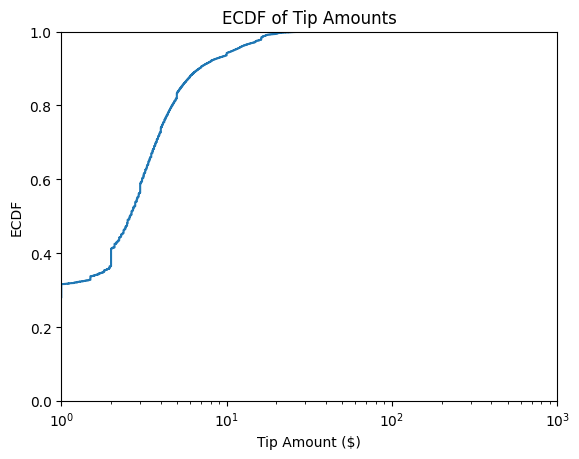

In [11]:
plt.ecdf(rides_df_raw["tip_amount"])
plt.xlim(1, 1000)
plt.xscale("log")
plt.title("ECDF of Tip Amounts")
plt.xlabel("Tip Amount ($)")
plt.ylabel("ECDF")
plt.show()

We can see some curious stuff in the target variable:
- `~35%` of rides had a `"tip_amount"` equal to zero.
- The next `~60%` of rides had a `"tip_amount"` between `$0` and `$10`.
- The remaining `~5%` of rides had a `"tip_amount"` of over `$10`.

#### Correlation

Like `pandas`, `polars` offers a convenient method on dataframes for checking correlation between columns (if you'd like to downsample the data for running this cell more quickly, you can uncomment the `.sample` call):

In [14]:
corr = (
    rides_df_raw
    .select(pl.col([pl.Int32, pl.Int64, pl.Float64]))
    .filter(
        pl.all_horizontal(pl.all().is_not_null())
    )
    .sample(100000)  # Uncomment for speed.
    .corr()
)
(
    corr
    .select(
        pl.Series(corr.columns),
        pl.all()
    )
)

,vendor_id,passenger_count,trip_distance,ratecode_id,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""vendor_id""",1.0,0.100437,-0.002909,-0.18862,0.000894,0.003916,0.024463,0.009875,-0.538039,-0.057528,0.044146,0.007612,-0.062942,0.017095,0.012341,0.038596
"""passenger_count""",0.100437,1.0,0.00427,-0.039935,-0.009087,-0.008356,0.016583,0.044332,-0.045498,-0.013156,0.020904,0.036733,-0.000663,0.04348,0.006646,0.028395
"""trip_distance""",-0.002909,0.00427,1.0,0.045577,-0.015818,-0.008338,-0.002273,0.117873,0.021802,-0.005335,0.076996,0.086053,0.000889,0.117331,-0.042238,0.087644
"""ratecode_id""",-0.18862,-0.039935,0.045577,1.0,-0.069534,-0.05817,-0.040806,0.102543,-0.090882,0.002169,-0.08175,0.053841,0.010291,0.057687,-0.299794,-0.021023
"""pu_location_id""",0.000894,-0.009087,-0.015818,-0.069534,1.0,0.082848,-0.01946,-0.111106,-0.042062,0.013346,-0.069142,-0.077082,0.009906,-0.110497,0.115842,-0.147482
"""do_location_id""",0.003916,-0.008356,-0.008338,-0.05817,0.082848,1.0,-0.024075,-0.080558,-0.001288,0.025146,-0.044399,-0.060263,0.009299,-0.075396,0.109707,-0.04078
"""payment_type""",0.024463,0.016583,-0.002273,-0.040806,-0.01946,-0.024075,1.0,-0.110278,-0.094431,-0.422782,-0.355707,-0.040645,-0.459017,-0.177024,-0.346036,-0.005934
"""fare_amount""",0.009875,0.044332,0.117873,0.102543,-0.111106,-0.080558,-0.110278,1.0,0.176529,0.097657,0.587743,0.60215,0.245497,0.979375,-0.11386,0.58286
"""extra""",-0.538039,-0.045498,0.021802,-0.090882,-0.042062,-0.001288,-0.094431,0.176529,1.0,0.162332,0.218,0.256213,0.156248,0.264489,0.088916,0.345379


By default, `polars` only shows `10` rows, so we can't see the whole chart. We can change that with `polars` config:

In [13]:
pl.Config.set_tbl_rows(16)

polars.config.Config

Unsurprisingly, `"tip_amount"` is highly correlated with `"total_amount"`; let's have a closer look, again using the built-in `.plot` namespace:

In [15]:
(
    rides_df_raw
    .sample(10000)
    .plot
    .scatter(
        x="total_amount",
        y="tip_amount",
        xlim=(0, 200),
        ylim=(0, 40),
    )
)

:Scatter   [total_amount]   (tip_amount)

There are a few interesting things here:
1. There are three distinct flat lines at `$5`, `$10`, and `$15`--these are common tip amounts.
2. There are three distinct diagonal lines at `y = {.15, .20, and .25} * total_amount`--these are common tip percentages.

`"tip_amount"` might be more predictable than we thought!

## 9.4. Cleaning and Preparing the Data

Over the course of this course, we've compiled some filters of impossible data, such as rides without passengers, and rides that had a pickup that occurred after the dropoff, and some of the other data issues we just discovered in the prior section (such as missing values). We'd like to handle this bad data before jumping into machine learning, so first let's quantify the scope of the issue:

In [16]:
rides_df_raw.describe()

statistic,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""",6.590154e6,"""6590154""","""6590154""",5.978354e6,6.590154e6,5.978354e6,"""5978354""",6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,5.978354e6,5.978354e6,"""6590154""","""6590154""","""6590154""","""6590154""","""6590154""","""6590154"""
"""null_count""",0.0,"""0""","""0""",611800.0,0.0,611800.0,"""611800""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,611800.0,611800.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",1.756811,"""2024-03-02 23:29:08.306262""","""2024-03-02 23:45:29.766303""",1.332109,4.217783,2.189424,null,164.836847,163.769507,1.103447,18.39262,1.400976,0.48309,3.241934,0.526057,0.974779,26.894141,2.259032,0.136208,null,null,null,null,null,null
"""std""",0.430632,null,null,0.836458,281.631336,10.395004,null,64.242165,69.446392,0.622692,18.359656,1.804078,0.119625,3.941163,2.122793,0.221227,22.897657,0.826409,0.48108,null,null,null,null,null,null
"""min""",1.0,"""2002-12-31 22:17:10""","""2002-12-31 22:42:24""",0.0,0.0,1.0,"""N""",1.0,1.0,0.0,-999.0,-7.5,-0.5,-300.0,-84.3,-1.0,-1000.0,-2.5,-1.75,"""Bronx""","""Allerton/Pelham Gardens""","""Airports""","""Bronx""","""Allerton/Pelham Gardens""","""Airports"""
"""25%""",2.0,"""2024-02-16 23:06:24""","""2024-02-16 23:22:02""",1.0,1.0,1.0,null,132.0,113.0,1.0,8.61,0.0,0.5,0.0,0.0,1.0,15.48,2.5,0.0,null,null,null,null,null,null
"""50%""",2.0,"""2024-03-03 14:05:02""","""2024-03-03 14:23:32""",1.0,1.71,1.0,null,162.0,162.0,1.0,13.5,1.0,0.5,2.6,0.0,1.0,20.43,2.5,0.0,null,null,null,null,null,null
"""75%""",2.0,"""2024-03-17 12:36:18""","""2024-03-17 12:54:35""",1.0,3.2,1.0,null,234.0,234.0,1.0,21.2,2.5,0.5,4.12,0.0,1.0,29.04,2.5,0.0,null,null,null,null,null,null
"""max""",6.0,"""2024-04-01 00:34:55""","""2024-04-02 18:08:46""",9.0,222478.29,99.0,"""Y""",265.0,265.0,4.0,9792.0,14.25,35.84,999.99,163.0,1.0,9792.0,2.5,1.75,"""Unknown""","""Yorkville West""","""Yellow Zone""","""Unknown""","""Yorkville West""","""Yellow Zone"""


In [17]:
currency_columns = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "airport_fee",
]

remove_impossible_data_filter = (
    
    # Data in expected time range.
    pl.col("tpep_pickup_datetime").ge(pl.date(2024, 2, 1)) &
    pl.col("tpep_pickup_datetime").lt(pl.date(2024, 4, 1)) &
    
    # Dropoff strictly after the pickup.
    pl.col("tpep_pickup_datetime").lt(pl.col("tpep_dropoff_datetime")) &
    
    # No trips with zero passengers.
    pl.col("passenger_count").gt(0) &
    
    # No negative values in currency columns or `"trip_distance"`.
    pl.all_horizontal(pl.col(["trip_distance"] + currency_columns).ge(0)) &
    
    # No missing values.
    pl.all_horizontal(pl.all().is_not_null())
    
)

In [18]:
(
    rides_df_raw
    .select(
        remove_impossible_data_filter.mean().alias("fraction_data_usable")
    )
)

fraction_data_usable
f64
0.883446


For our cases, it's fine to remove!

Before removing data, though, let's first prepare to split our data into train and test. We'll do that by splitting the data into 80% and 20%, over time:

In [19]:
TRAIN_TEST_SPLIT_FRACTION = .8
rides_df = (
    rides_df_raw
    .filter(remove_impossible_data_filter)
    .with_columns(
        pl.col("tpep_pickup_datetime").lt(
            pl.col("tpep_pickup_datetime").min() +
            TRAIN_TEST_SPLIT_FRACTION * (
                pl.col("tpep_pickup_datetime").max() -
                pl.col("tpep_pickup_datetime").min()
            )
        ).alias("is_train")
    )
)

In [21]:
rides_df.head()

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone,is_train
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,bool
2,2024-02-01 00:04:45,2024-02-01 00:19:58,1,4.39,1,"""N""",68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0,"""Manhattan""","""East Chelsea""","""Yellow Zone""","""Manhattan""","""Upper East Side North""","""Yellow Zone""",true
2,2024-02-01 00:56:31,2024-02-01 01:10:53,1,7.71,1,"""N""",48,243,1,31.0,1.0,0.5,9.0,0.0,1.0,45.0,2.5,0.0,"""Manhattan""","""Clinton East""","""Yellow Zone""","""Manhattan""","""Washington Heights North""","""Boro Zone""",true
2,2024-02-01 00:07:50,2024-02-01 00:43:12,2,28.69,2,"""N""",132,261,2,70.0,0.0,0.5,0.0,6.94,1.0,82.69,2.5,1.75,"""Queens""","""JFK Airport""","""Airports""","""Manhattan""","""World Trade Center""","""Yellow Zone""",true
1,2024-02-01 00:01:49,2024-02-01 00:10:47,1,1.1,1,"""N""",161,163,1,9.3,3.5,0.5,2.85,0.0,1.0,17.15,2.5,0.0,"""Manhattan""","""Midtown Center""","""Yellow Zone""","""Manhattan""","""Midtown North""","""Yellow Zone""",true
1,2024-02-01 00:37:35,2024-02-01 00:51:15,1,2.6,1,"""N""",246,79,2,15.6,3.5,0.5,0.0,0.0,1.0,20.6,2.5,0.0,"""Manhattan""","""West Chelsea/Hudson Yards""","""Yellow Zone""","""Manhattan""","""East Village""","""Yellow Zone""",true


Time for some ML!

## 9.5. Feature Engineering and Selection

In [22]:
rides_df.head(1)

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone,is_train
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,bool
2,2024-02-01 00:04:45,2024-02-01 00:19:58,1,4.39,1,"""N""",68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0,"""Manhattan""","""East Chelsea""","""Yellow Zone""","""Manhattan""","""Upper East Side North""","""Yellow Zone""",true


Earlier in this course, we saw that more rides took place on the weekend; perhaps `"is_weekend"` would have something to do with `"tip_amount"`, so let's add that as a feature. It'll also be curious to include `"is_airport_dropoff"` and `"is_airport_pickup"` as features, which we can extract from the pickup and dropoff location names.

Let's select a basic list of features for an ML experiment:
- `"is_weekend"`
- `"is_airport_dropoff"`
- `"is_airport_pickup"`
- `"trip_distance"`
- `"passenger_count"`
- `"total_amount"`

And of course we'll need to still include `"tip_amount"`:

In [23]:
FEATURES = [
    "is_weekend",
    "pu_zone_is_airport",
    "do_zone_is_airport",
    "trip_distance",
    "passenger_count",
    "total_amount"
]
TARGET = "tip_amount"
TRAIN_TEST_COLUMN = "is_train"

features_df = (
    rides_df
    .with_columns([
        pl.col("tpep_pickup_datetime").dt.weekday().is_in({5, 6, 7}).alias("is_weekend"),
        pl.col(["pu_zone", "do_zone"]).str.contains("Airport").name.suffix("_is_airport"),
    ])
    .select(
        *FEATURES,
        TARGET,
        TRAIN_TEST_COLUMN
    )
)

Taking a quick look at the new `features_df`:

In [24]:
features_df.head()

is_weekend,pu_zone_is_airport,do_zone_is_airport,trip_distance,passenger_count,total_amount,tip_amount,is_train
bool,bool,bool,f64,i64,f64,f64,bool
false,false,false,4.39,1,26.78,1.28,true
false,false,false,7.71,1,45.0,9.0,true
false,true,false,28.69,2,82.69,0.0,true
false,false,false,1.1,1,17.15,2.85,true
false,false,false,2.6,1,20.6,0.0,true


Perfect! Time for some machine learning 🤓

## 9.6. Model Building

We'll try a basic LGBM regression model. To that end, scikit-learn, LGBM, and XGBoost can all accept `polars` series and dataframes with no extra modification:

In [25]:
model = LGBMRegressor()  # Just use the default model params, for the sake of the demo.
X_train = features_df.filter(pl.col("is_train")).select(FEATURES)
y_train = features_df.filter(pl.col("is_train")).select(TARGET).to_series()
X_test = features_df.filter(pl.col("is_train").not_()).select(FEATURES)
y_test = features_df.filter(pl.col("is_train").not_()).select(TARGET).to_series()

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 4661711, number of used features: 6
[LightGBM] [Info] Start training from score 3.533960


LGBMRegressor()

Now let's evaluate!

## 9.7. Model Evaluation

In [26]:
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print(f"The mean absolute error of our prediction of `tip_amount` is ${mae:.02f}")

The mean absolute error of our prediction of `tip_amount` is $1.13


## 9.8. Discussion

To understand what we could have done to help the model perform a bit better, let's plot the predictions of `"tip_amount"` against the known values of `"tip_amount"`, using `polars`'s `plot` again:

In [27]:
(
    pl.DataFrame({
        "tip_amount_true": y_test,
        "tip_amount_predicted": y_predicted,
        "absolute_error": (y_test - y_predicted).abs()
    })
    .sample(1000)
    .plot
    .scatter(
        x="tip_amount_true",
        y="tip_amount_predicted"
    )
)

:Scatter   [tip_amount_true]   (tip_amount_predicted)

There are a few things to take note of:
- Many rides had a tip of `$0`, that our model predicted as having a nonzero tip. One approach for fixing this would be to introduce a piecewise modeling approach that appreciates the piecewise nature of the `"tip_amount"` distribution. More specifically, we could introduce a two step model--the first model predicts whether the tip is zero or non-zero, and if the first model predicts a nonzero tip, a second model predicts the exact tip amount.
- Not only is there a spike at `tip_amount = $0`, but also at `$5` and `$10`. Perhaps there's a way to better incorporate into the model output our prior knowledge that tips are very often given in fixed amounts (`$0`, `$5`, `$10`, ...) or fixed percentages (`15%`, `20%`, `25%`, ...) as we saw in the exploration.
- The prediction eror appears to increase as a function of `"tip_amount"`, though this makes sense--higher values are more difficult to predict precisely. It nonetheless raises the question, though: should we change the objective function from LGBM's [default RMSE (root mean square error)](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters) to something that doesn't punish as highly for high errors for high values of `"tip_amount_true"`, such as MAPE (mean absolute percentage error)?

And of course, we could add more features or try new models besides LGBM, introduce cross-validation or hyperparameter tuning... but for now that's it!

## Conclusion

In this module, we walked through an example data science problem, learning a few new polars tricks such as `plot`, `corr`, and `sample`, and seeing how seamlessly `polars` integrates with the rest of the Python data science toolstack.